##LSTM Stock Predictor Using Closing Prices


>In this notebook, we will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin closing prices to predict the 11th day closing price. 

We will need to:
1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

### Data Preperation

>In this section, we will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:
1. Use the window_data function to generate the X and y values for the model. 
2. Split the data into 70% training and 30% testing 
3. Apply the MinMaxScaler to the X and y values 
4. Reshape the X_train and X_test data for the model.

 Note: The required input format for the LSTM is:

>reshape((X_train.shape[0], X_train.shape[1], 1))


In [154]:
import numpy as np
import pandas as pd
import hvplot.pandas

%matplotlib inline


In [155]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and 
# run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [156]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
#Transform the "Date" column to datetime
df = df.drop(columns="fng_classification")

df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [157]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [158]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")


df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [159]:
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [160]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [161]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 1  ## Feature column is the fng_value
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [165]:
# Use 70% of the data for training and the remaineder for testing
# TRAIN-TEST SPLIT

split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]


In [166]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
# Create a MinMaxScaler object
scaler = MinMaxScaler()
# Fit the MinMaxScaler object with the features data X
scaler.fit(X)
# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
# Fit the MinMaxScaler object with the target data Y
scaler.fit(y)
# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)



In [167]:
df

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078
...,...,...
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531


In [168]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.60761794]
  [0.58242373]
  [0.62172321]
  [0.51499412]
  [0.38267307]
  [0.46160996]
  [0.4503991 ]
  [0.5193988 ]
  [0.56445096]
  [0.55127638]]

 [[0.58242373]
  [0.62172321]
  [0.51499412]
  [0.38267307]
  [0.46160996]
  [0.4503991 ]
  [0.5193988 ]
  [0.56445096]
  [0.55127638]
  [0.5012101 ]]

 [[0.62172321]
  [0.51499412]
  [0.38267307]
  [0.46160996]
  [0.4503991 ]
  [0.5193988 ]
  [0.56445096]
  [0.55127638]
  [0.5012101 ]
  [0.58660203]]] 

X_test sample values:
[[[0.04675556]
  [0.03913222]
  [0.03975922]
  [0.03856719]
  [0.03679562]
  [0.03728835]
  [0.03974167]
  [0.04528668]
  [0.04528668]
  [0.07024855]]

 [[0.03913222]
  [0.03975922]
  [0.03856719]
  [0.03679562]
  [0.03728835]
  [0.03974167]
  [0.04528668]
  [0.04528668]
  [0.07024855]
  [0.07145402]]

 [[0.03975922]
  [0.03856719]
  [0.03679562]
  [0.03728835]
  [0.03974167]
  [0.04528668]
  [0.04528668]
  [0.07024855]
  [0.07145402]
  [0.07659928]]]


## Build and Train the SLTM RNN

> In this section, you will design a custom LSTM RNN in Keras and fit (train) it using the training data we defined.You will need to:

1. Define the model architecture in Keras. 
2. Compile the model. 
3. Fit the model with the training data.

In [169]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [175]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()

# Initial model setup
number_units = 10
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(units = number_units,
              return_sequences = True,
              input_shape = (X_train.shape[1], 1)))
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units = number_units,
              return_sequences = True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units = number_units))
model.add(Dropout(dropout_fraction))

# Output Layer
model.add(Dense(1))


model.summary()



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10, 10)            480       
                                                                 
 dropout_3 (Dropout)         (None, 10, 10)            0         
                                                                 
 lstm_9 (LSTM)               (None, 10, 10)            840       
                                                                 
 dropout_4 (Dropout)         (None, 10, 10)            0         
                                                                 
 lstm_10 (LSTM)              (None, 10)                840       
                                                                 
 dropout_5 (Dropout)         (None, 10)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [176]:
# Compile the model

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [177]:
# Summarize the model
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10, 10)            480       
                                                                 
 dropout_3 (Dropout)         (None, 10, 10)            0         
                                                                 
 lstm_9 (LSTM)               (None, 10, 10)            840       
                                                                 
 dropout_4 (Dropout)         (None, 10, 10)            0         
                                                                 
 lstm_10 (LSTM)              (None, 10)                840       
                                                                 
 dropout_5 (Dropout)         (None, 10)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [178]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended

model.fit(X_train, y_train, epochs = 10, shuffle = False, batch_size = 90, verbose = 1)


Epoch 1/10
5/5 [==============================] - 8s 20ms/step - loss: 0.1557
Epoch 2/10
5/5 [==============================] - 0s 19ms/step - loss: 0.1354
Epoch 3/10
5/5 [==============================] - 0s 21ms/step - loss: 0.1172
Epoch 4/10
5/5 [==============================] - 0s 19ms/step - loss: 0.1002
Epoch 5/10
5/5 [==============================] - 0s 22ms/step - loss: 0.0835
Epoch 6/10
5/5 [==============================] - 0s 21ms/step - loss: 0.0664
Epoch 7/10
5/5 [==============================] - 0s 21ms/step - loss: 0.0514
Epoch 8/10
5/5 [==============================] - 0s 22ms/step - loss: 0.0406
Epoch 9/10
5/5 [==============================] - 0s 21ms/step - loss: 0.0345
Epoch 10/10
5/5 [==============================] - 0s 20ms/step - loss: 0.0311


## Model Performance

>In this section, you will evaluate the model using the test data. You will need to:

1. Evaluate the model using the X_test and y_test data. 
2. Use the X_test data to make predictionsCreate a DataFrame of Real (y_test) vs predicted values. 
3. Plot the Real vs predicted values as a line chart


In [179]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose = 0)


0.044202812016010284

In [180]:
# Make some predictions

predicted = model.predict(X_test)


In [181]:
predicted

array([[0.25348446],
       [0.25361538],
       [0.25434512],
       [0.25526497],
       [0.25644794],
       [0.257987  ],
       [0.25954866],
       [0.26099366],
       [0.26212966],
       [0.2631929 ],
       [0.26303783],
       [0.26275393],
       [0.26218298],
       [0.2617309 ],
       [0.2609672 ],
       [0.25941882],
       [0.25967005],
       [0.25962135],
       [0.25974092],
       [0.25987965],
       [0.2601282 ],
       [0.2603742 ],
       [0.26059136],
       [0.26096216],
       [0.261715  ],
       [0.26181737],
       [0.26199806],
       [0.2622241 ],
       [0.26258814],
       [0.26265648],
       [0.26290256],
       [0.26346147],
       [0.2639919 ],
       [0.26459363],
       [0.26518628],
       [0.2655174 ],
       [0.26532605],
       [0.26528102],
       [0.26530552],
       [0.2652406 ],
       [0.2651156 ],
       [0.26536244],
       [0.2656952 ],
       [0.26653856],
       [0.26812738],
       [0.27068934],
       [0.27381438],
       [0.277

In [182]:
##Transformback to original form

predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1,1))


In [133]:
predicted_prices

array([[ 0.14543995,  0.14593078, -0.0582684 , ...,  0.15524614,
         0.15326323,  0.14539674],
       [ 0.14543995,  0.14593078, -0.0582684 , ...,  0.15524614,
         0.15326323,  0.14539674],
       [ 0.14543995,  0.14593078, -0.0582684 , ...,  0.15524614,
         0.15326323,  0.14539674],
       ...,
       [ 0.14544033,  0.1459309 , -0.0582682 , ...,  0.15524624,
         0.15326379,  0.1453966 ],
       [ 0.14544027,  0.14593086, -0.05826823, ...,  0.15524621,
         0.1532637 ,  0.14539658],
       [ 0.1454402 ,  0.14593084, -0.05826825, ...,  0.15524621,
         0.15326361,  0.14539659]], dtype=float32)

In [134]:
real_prices

array([[4.41679675e-03],
       [4.09606745e-01],
       [4.33930909e-03],
       [4.02416662e-01],
       [4.18433377e-03],
       [4.11505987e-01],
       [4.41679675e-03],
       [3.90581216e-01],
       [2.63458052e-03],
       [3.93133655e-01],
       [4.18433377e-03],
       [3.93068577e-01],
       [3.33196948e-03],
       [3.99649580e-01],
       [4.02935844e-03],
       [3.89706377e-01],
       [3.25448182e-03],
       [4.03308564e-01],
       [4.10684610e-03],
       [4.05125627e-01],
       [4.33930909e-03],
       [4.09270460e-01],
       [4.10684610e-03],
       [4.09718323e-01],
       [4.18433377e-03],
       [4.12093350e-01],
       [4.18433377e-03],
       [4.10509506e-01],
       [4.10684610e-03],
       [4.17400460e-01],
       [4.64925974e-03],
       [4.28592017e-01],
       [4.41679675e-03],
       [4.22042758e-01],
       [3.87438312e-03],
       [3.99423322e-01],
       [2.55709286e-03],
       [4.04957485e-01],
       [2.63458052e-03],
       [4.04600278e-01],


In [183]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()},
    index = df.index[-len(real_prices):])

# show the head of stocks
stocks.head()


,Real,Predicted
2019-02-20,3924.239990,5686.435059
2019-02-21,3974.050049,5687.702148
2019-02-22,3937.040039,5694.766602
2019-02-23,3983.530029,5703.671875
2019-02-24,4149.089844,5715.124023


In [184]:
real_df = pd.DataFrame(real_prices.ravel())
predicted_df = pd.DataFrame(predicted_prices.ravel())
predicted_df

,0
0,5686.435059
1,5687.702148
2,5694.766602
3,5703.671875
4,5715.124023
...,...
155,7610.891602
156,7612.811523
157,7586.813965
158,7614.956543


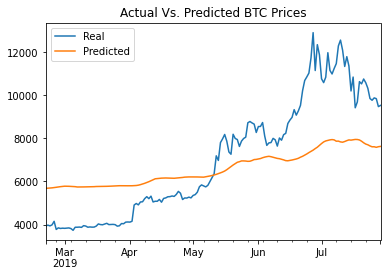

In [185]:
 #Plot the real vs predicted prices as a line chart
stocks.plot(title = 'Actual Vs. Predicted BTC Prices')